### Model Testing

In [1]:
import os
import sys
import time

import numpy as np
import torch

import matplotlib.pyplot as plt

import scipy.io.wavfile as wav

import importlib
import librosa
import soundfile as sf

import torchnet.meter as tnt
from collections import OrderedDict

from IPython.display import clear_output
from scipy.io.wavfile import write
import IPython

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))
sys.path.append(os.path.join(os.getcwd(), '../datasets/'))

import ai8x

from types import SimpleNamespace
from msnoise import MSnoise
import msnoise

from mixedkws import MixedKWS
import mixedkws

from kws20 import KWS

import pandas as pd

In [2]:
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-synthesis/trained/","ai85-kws20_v3-qat8.pth.tar")              #degisecek
mod = importlib.import_module("ai85net-kws20-v3")
dataset = importlib.import_module("kws20")

classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']
           
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
# qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

# args = ('/data_ssd', Namespace(act_mode_8bit=False, activation_stats=[], avg_pool_rounding=False, batch_size=256, cnn='ai85kws20netv3', collate_fn=None, compress='policies/schedule_kws20.yaml', cpu=False, csv_prefix=None, data='/data_ssd', dataset='KWS_20', datasets_fn=<function KWS_20_get_datasets at 0x7f917f0f2040>, deterministic=True, device='cuda', dimensions=(128, 128, 1), display_confusion=True, display_embedding=False, display_prcurves=False, earlyexit_lossweights=None, earlyexit_thresholds=None, effective_test_size=1.0, effective_train_size=1.0, effective_valid_size=1.0, epochs=200, evaluate=False, extras=None, generate_sample=None, gpus=None, kd_distill_wt=0.5, kd_pretrained=False, kd_resume='', kd_start_epoch=0, kd_student_wt=0.5, kd_teacher=None, kd_teacher_wt=0.0, kd_temp=1.0, kernel_stats=False, labels=('up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'UNKNOWN'), load_model_path='', load_serialized=False, log_params_histograms=False, lr=0.001, masks_sparsity=False, momentum=0.9, name=None, nas=False, nas_kd_resume_from='', nas_policy='', nas_stage_transition_list=None, no_tensorboard=True, num_best_scores=1, num_classes=21, obj_detection=False, obj_detection_params=None, optimizer='Adam', out_fold_ratio=1, output_dir='logs', pretrained=False, print_freq=10, qat_policy='policies/qat_policy.yaml', qe_bits_accum=32, qe_bits_acts=8, qe_bits_wts=8, qe_calibration=None, qe_clip_acts=<ClipMode.NONE: 0>, qe_clip_n_stds=None, qe_config_file=None, qe_convert_pytorch=False, qe_dynamic=False, qe_mode=<LinearQuantMode.SYMMETRIC: 1>, qe_mode_acts=None, qe_mode_wts=None, qe_no_clip_layers=[], qe_no_quant_layers=[], qe_per_channel=False, qe_pytorch_backend='fbgemm', qe_save_fp_weights=False, qe_scale_approx_bits=None, qe_stats_file=None, quantize_eval=False, regression=False, reset_optimizer=False, resumed_checkpoint_path='', seed=None, sensitivity=None, sensitivity_range=[0.0, 0.95, 0.05], shap=0, show_train_accuracy='last_batch', sparsity_perf=False, summary=None, summary_filename='model', tblog=False, thinnify=False, truncate_testset=False, use_bias=False, validation_split=0.1, visualize_fn=<function visualize_data at 0x7f8fface3790>, weight_decay=0.0, workers=4))

_, test_dataset = dataset.KWS_20_get_datasets( ('/data_ssd', sn), load_train=False, load_test=True)
_, test_noise = msnoise.MSnoise_get_datasets(('/data_ssd', sn), load_train=False, load_test=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

Working with device: cuda
Configuring device: MAX78000, simulate=False.
No key `strech` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]
Processing the label: backward. 1 of 36
Finished in 0.628 seconds.
Processing the label: bed. 2 of 36
Finished in 0.258 seconds.
Processing the label: bird. 3 of 36
Finished in 0.264 seconds.
Processing the label: cat. 4 of 36
Finished in 0.261 seconds.
Processing the label: dog. 5 of 36
Finished in 0.273 seconds.
Processing the label: down. 6 of 36
Finished in 0.502 seconds.
Processing the label: eight. 7 of 36
Finished in 0.486 seconds.
Processing the label: five. 8 of 36
Finished in 0.520 seconds.
Processing the label: follow. 9 of 36
Finished in 0.203 seconds.
Processing the label: forward. 10 of 36
Finished in 0.200 seconds.
Processing the label: four. 11 of 36
Finished in 0.478 seconds.
Processing the label: go. 12 of 36
Finished in 0.497 seconds.
Processing the label: happy. 13 of 36
Finished in 0.264 seconds.
Processing t

### Examples

In [3]:
test_sample, test_target = test_dataset[0]
noise_sample, noise_target = test_noise[0]

mixed_sample = MixedKWS.snr_mixer(test_sample, noise_sample, -5)

In [4]:
write('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', 16384, np.array(test_sample).flatten('F'))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', rate = 16384)

In [5]:
write('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', 16384, np.array(noise_sample).flatten('F'))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', rate = 16384)

In [6]:
write('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', 16384, np.array(mixed_sample).flatten('F'))
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/test.wav', rate = 16384)

### Functions for evaluation

In [3]:
class_dict = {}
class_nums = test_noise.targets.unique()

for idx, i in enumerate(test_noise.classes):
    class_dict[i] = idx

noise_classes = {}
start = 0
end = 0

for i in test_noise.classes:
    
    val = class_dict[i]
    val = list(test_noise.targets).count(val)
    
    if val == 0:
        continue

    end += val
    noise_classes[i] = (start, end)

    start = end

In [4]:
def evaluate(model, data, db, noise, noise_kind):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
    outputs_all = np.zeros((len(test_dataset), 21))
    targets_all = np.zeros((len(test_dataset)))

    if (noise == True) and (noise_kind != 'WhiteNoise'):
        low, high = noise_classes[noise_kind]

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data):

            if noise == True:
                if noise_kind == 'WhiteNoise':

                    rmsclean = torch.mean(data[:, :125]**2)**0.5
                    rmsnoise = ((rmsclean**2)/(10**(db/10)))**0.5
                    noise = np.random.normal(0, rmsnoise, data.shape[0])
                    inputs = data + noise

                else:

                    n_noise = np.random.randint(low, high, inputs.shape[0])
                    random_noise = torch.tensor(test_noise.data[n_noise], dtype = torch.float32)

                    inputs = MixedKWS.snr_mixer(inputs, random_noise, db)

            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(test_dataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
            targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
            
    print("Total Accuracy: ", acc)
    return acc

evaluate()

In [5]:
def snr_testing(trained_checkpoint_path, model, data_loader, noise = False, noise_kind = None):

    if noise == False:
        db = None

    time_s = time.time()
    print("Started evaluating :", trained_checkpoint_path)

    if noise == False:
        accuracies = np.zeros(1)
        snr = np.zeros(1)

        accuracies[0] = evaluate(model, data_loader, db, noise, noise_kind)
        snr[0] = None
        
        dur = time.time() - time_s
        print(f'Finished in {dur:.3f} seconds.')
        return accuracies, snr
    
    snr_low = torch.tensor(-5, dtype=torch.int32)
    snr_high = torch.tensor(35, dtype=torch.int32)
    
    accuracies = np.zeros(6)
    snr = np.zeros(6)

    idx = 0
    for db in range(snr_low, snr_high):
        if db in [-5, 0, 5, 10, 20, 30]:
            print("Evaluating SNR levels of", db)
            accuracies[idx] = evaluate(model, data_loader, db, noise, noise_kind)
            snr[idx] = db
            idx += 1
    
    dur = time.time() - time_s
    print(f'Finished in {dur:.3f} seconds.')
    return accuracies, snr

In [6]:
def benchmark(models, checkpoint_paths, noise_kinds):

    num = len(noise_kinds) + 2

    snr = np.zeros((num, 6))
    accuracies = np.zeros((num, 6))

    #for idx, n in enumerate(noise_kinds):

    #    print(f'{n} Noise Evaluation')

    #    accuracies[idx], snr[idx] = snr_testing(trained_checkpoint_path, model, test_loader, noise = True, noise_kind = n)

    #accuracies[-2], snr[-2] = snr_testing(trained_checkpoint_path, model, test_loader)
    accuracies[-1], snr[-1] = snr_testing(trained_checkpoint_path, model, test_loader, noise= False)

    return accuracies, snr

In [7]:
list(noise_classes.keys())

['AirConditioner',
 'AirportAnnouncements',
 'Babble',
 'Bus',
 'Car',
 'CopyMachine',
 'ShuttingDoor',
 'Typing',
 'VacuumCleaner']

In [12]:
accuracies, snr = benchmark(model, trained_checkpoint_path, noise_kinds= list(noise_classes.keys()))

AirConditioner Noise Evaluation
Started evaluating : /home/merveeyuboglu/Github/ai8x-synthesis/trained/ai85-kws20_v3-qat8.pth.tar
Evaluating SNR levels of -5


/tmp/ipykernel_2726948/3463589052.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_noise = torch.tensor(test_noise.data[n_noise], dtype = torch.float32)


Batch: [ 0 / 12914 ]
Accuracy:  13.671875
Batch: [ 256 / 12914 ]
Accuracy:  14.0625
Batch: [ 512 / 12914 ]
Accuracy:  12.630208333333337
Batch: [ 768 / 12914 ]
Accuracy:  12.20703125
Batch: [ 1024 / 12914 ]
Accuracy:  18.125000000000004
Batch: [ 1280 / 12914 ]
Accuracy:  20.833333333333336
Batch: [ 1536 / 12914 ]
Accuracy:  21.707589285714292
Batch: [ 1792 / 12914 ]
Accuracy:  24.12109375
Batch: [ 2048 / 12914 ]
Accuracy:  24.522569444444443
Batch: [ 2304 / 12914 ]
Accuracy:  23.320312499999996
Batch: [ 2560 / 12914 ]
Accuracy:  23.046875
Batch: [ 2816 / 12914 ]
Accuracy:  23.4375
Batch: [ 3072 / 12914 ]
Accuracy:  24.158653846153843
Batch: [ 3328 / 12914 ]
Accuracy:  23.10267857142857
Batch: [ 3584 / 12914 ]
Accuracy:  22.291666666666664
Batch: [ 3840 / 12914 ]
Accuracy:  23.14453125
Batch: [ 4096 / 12914 ]
Accuracy:  23.943014705882348
Batch: [ 4352 / 12914 ]
Accuracy:  22.916666666666664
Batch: [ 4608 / 12914 ]
Accuracy:  22.162828947368418
Batch: [ 4864 / 12914 ]
Accuracy:  21.7382

In [11]:
accuracies_w, snr_w = benchmark(model, trained_checkpoint_path, noise_kinds =  [])

Started evaluating : /home/merveeyuboglu/Github/ai8x-synthesis/trained/ai85-kws20_v3-qat8.pth.tar
Batch: [ 0 / 12914 ]
Accuracy:  86.71875
Batch: [ 256 / 12914 ]
Accuracy:  83.984375
Batch: [ 512 / 12914 ]
Accuracy:  83.59375
Batch: [ 768 / 12914 ]
Accuracy:  83.984375
Batch: [ 1024 / 12914 ]
Accuracy:  86.640625
Batch: [ 1280 / 12914 ]
Accuracy:  88.671875
Batch: [ 1536 / 12914 ]
Accuracy:  90.17857142857143
Batch: [ 1792 / 12914 ]
Accuracy:  91.357421875
Batch: [ 2048 / 12914 ]
Accuracy:  90.79861111111111
Batch: [ 2304 / 12914 ]
Accuracy:  89.375
Batch: [ 2560 / 12914 ]
Accuracy:  90.16335227272727
Batch: [ 2816 / 12914 ]
Accuracy:  90.88541666666666
Batch: [ 3072 / 12914 ]
Accuracy:  91.19591346153845
Batch: [ 3328 / 12914 ]
Accuracy:  90.98772321428571
Batch: [ 3584 / 12914 ]
Accuracy:  89.84375
Batch: [ 3840 / 12914 ]
Accuracy:  90.283203125
Batch: [ 4096 / 12914 ]
Accuracy:  90.76286764705883
Batch: [ 4352 / 12914 ]
Accuracy:  90.95052083333334
Batch: [ 4608 / 12914 ]
Accuracy: 

In [12]:
accuracies_w

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [94.07619638, 94.07619638, 94.07619638, 94.07619638, 94.07619638,
        94.07619638]])

#### csv olusturma

In [13]:
csv_dict = {}

for idx, i in enumerate(list(noise_classes.keys())):
    csv_dict[i] = (accuracies[idx])

In [14]:
csv_dict

{'AirConditioner': array([25.63884157, 43.10825461, 60.26792628, 74.31469723, 89.70109958,
        92.93789686]),
 'AirportAnnouncements': array([31.40003097, 45.04413814, 59.85751897, 72.8124516 , 87.75747251,
        92.55072015]),
 'Babble': array([19.65308967, 33.56822054, 49.6825151 , 66.12978163, 86.06938207,
        92.24872232]),
 'Bus': array([71.90645811, 81.89561716, 87.41675701, 90.62258015, 93.12374168,
        93.43348304]),
 'Car': array([70.69072325, 81.05157194, 87.07604151, 90.70775902, 92.96887099,
        93.44122658]),
 'CopyMachine': array([39.99535388, 54.32863559, 67.81787208, 77.29595788, 89.12033452,
        92.32615766]),
 'ShuttingDoor': array([59.73362243, 69.21170822, 78.19420784, 83.86247483, 91.03298746,
        93.04630633]),
 'Typing': array([46.57735791, 60.76351247, 72.39430076, 81.42326158, 89.83273966,
        92.88369212]),
 'VacuumCleaner': array([ 7.02338547, 16.439523  , 32.63899644, 50.41040731, 74.81028341,
        87.80393372])}

writing csv

In [17]:
df = pd.DataFrame(csv_dict)
df.to_csv('/home/merveeyuboglu/Github/ai8x-training/codes/csv_dict.csv')

#### plotting

In [20]:
snr = [-5, 0, 5, 10, 20, 30]

In [21]:
file = pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/csv_dict.csv')
file['snr'] =snr

In [26]:
file[file.columns[1:-1]]

,AirConditioner,AirportAnnouncements,Babble,Bus,Car,CopyMachine,ShuttingDoor,Typing,VacuumCleaner
0,25.638842,31.400031,19.653090,71.906458,70.690723,39.995354,59.733622,46.577358,7.023385
1,43.108255,45.044138,33.568221,81.895617,81.051572,54.328636,69.211708,60.763512,16.439523
2,60.267926,59.857519,49.682515,87.416757,87.076042,67.817872,78.194208,72.394301,32.638996
3,74.314697,72.812452,66.129782,90.622580,90.707759,77.295958,83.862475,81.423262,50.410407
4,89.701100,87.757473,86.069382,93.123742,92.968871,89.120335,91.032987,89.832740,74.810283
5,92.937897,92.550720,92.248722,93.433483,93.441227,92.326158,93.046306,92.883692,87.803934


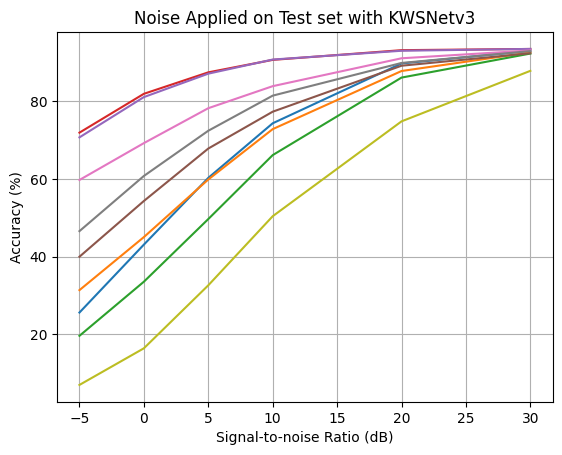

In [30]:
for col in file[file.columns[1:-1]].columns:

    plt.plot(file.snr.values, file[col].values)
    plt.title("Noise Applied on Test set with KWSNetv3")
    plt.xlabel('Signal-to-noise Ratio (dB)')
    plt.ylabel('Accuracy (%)')
    plt.grid()

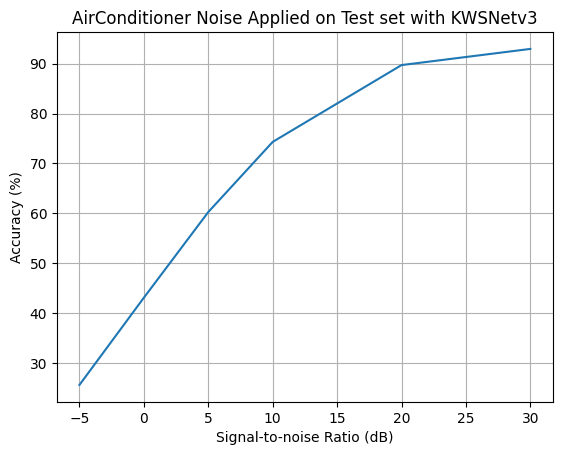

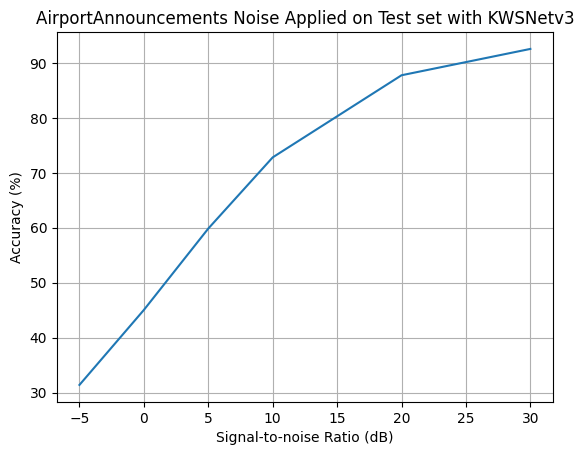

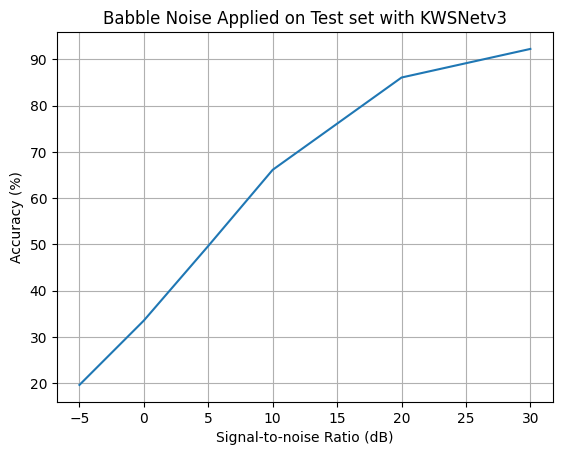

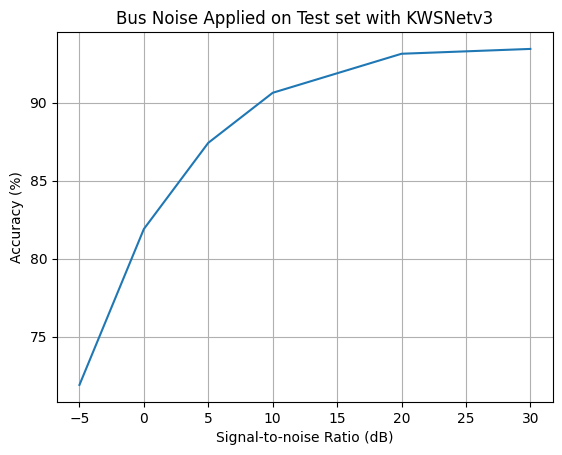

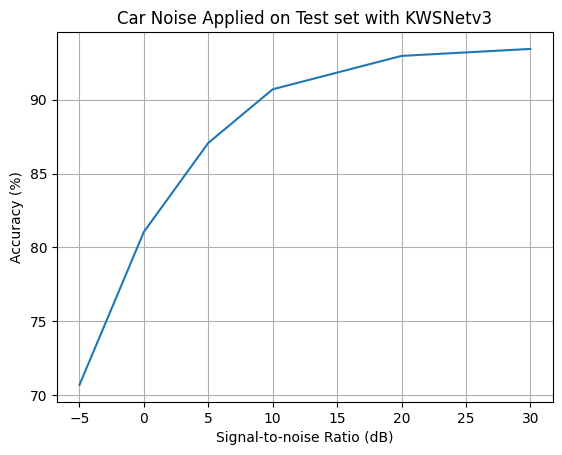

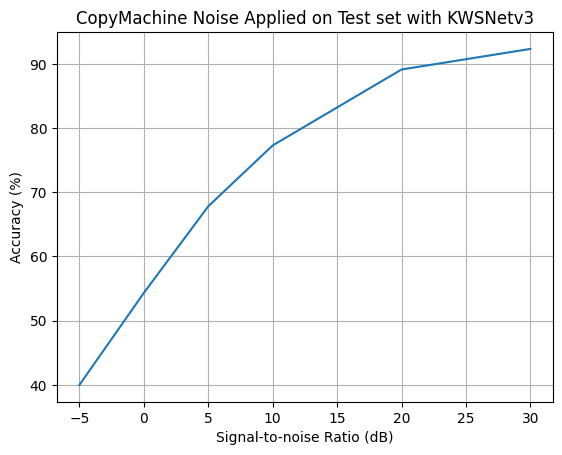

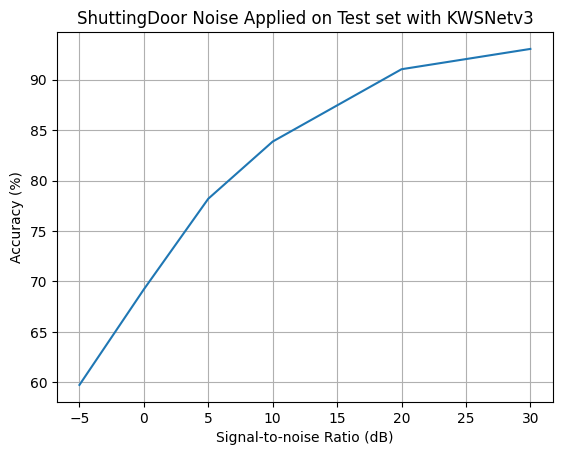

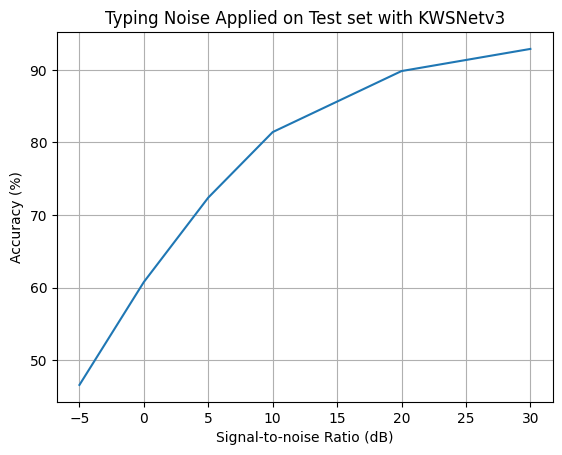

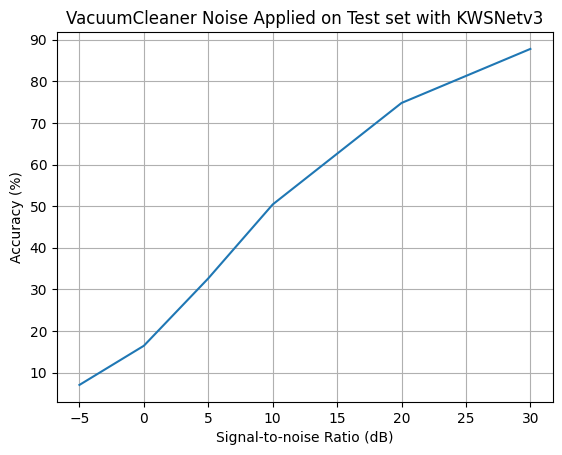

In [28]:
for col in file[file.columns[1:-1]].columns:
        plt.figure()
        plt.plot(file.snr.values, file[col].values)
        plt.title(f"{col} Noise Applied on Test set with KWSNetv3")
        plt.xlabel('Signal-to-noise Ratio (dB)')
        plt.ylabel('Accuracy (%)')
        plt.grid()